## Import Library

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.preprocessing import LabelEncoder
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
df = pd.read_csv('sms_spam.csv')
df

,Unnamed: 0,v1,v2
0,0,ham,"Go until jurong point, crazy.. Available only ..."
1,1,ham,Ok lar... Joking wif u oni...
2,2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,3,ham,U dun say so early hor... U c already then say...
4,4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...,...
5567,5567,spam,This is the 2nd time we have tried 2 contact u...
5568,5568,ham,Will _ b going to esplanade fr home?
5569,5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,5570,ham,The guy did some bitching but I acted like i'd...


## Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5572 non-null   int64 
 1   v1          5572 non-null   object
 2   v2          5572 non-null   object
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


In [4]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [5]:
df.rename(columns={'v1':'Type','v2':'Message'},inplace=True)
df.head()

,Type,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
label_encoder = LabelEncoder()

df['Type'] = label_encoder.fit_transform(df['Type'])

df.head()

,Type,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
print(label_encoder.classes_)

['ham' 'spam']


**Check for missing values**

In [8]:
df.isnull().sum()

Type       0
Message    0
dtype: int64

**Check for duplicate values**

In [9]:
df.duplicated().sum()

np.int64(404)

In [10]:
df = df.drop_duplicates(keep='first')
df.shape

(5168, 2)

## Data Preprocessing

In [11]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

set lookup: O(1) time (fast)

list lookup: O(n) time (slow if the list is long)

In [12]:
len(stop_words)

198

In [13]:
def preprocess(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    token = []

    for word in tokens:
        if word.isalnum() :
            token.append(word)
    return ' '.join(token)    

In [14]:
df['Preprocessed_text'] = df['Message'].apply(preprocess)

In [15]:
df

,Type,Message,Preprocessed_text
0,0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah i do think he goes to usf he lives around ...
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,this is the 2nd time we have tried 2 contact u...
5568,0,Will _ b going to esplanade fr home?,will b going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",pity was in mood for that so any other suggest...
5570,0,The guy did some bitching but I acted like i'd...,the guy did some bitching but i acted like i b...


## Model Building and Testing

Here spam = 1 and ham = 0  
i.e.  spam = positive class and ham = negative class

In confusion matrix,    
**TP** = Spam predicted as spam    
**FP** = Ham wrongly predicted as spam    
**FN** = Spam wrongly predicted as ham    
**TN** = Ham correctly predicted as ham   

Our goal is classify in such a way that **Ham cannot wrongly predicted as spam**  or  **Predictio of Ham wrongly as spam must be very less**    

That's why we try to make ourr accuracy is higher with precision as 1 or almost near 1

**Contextual Text Augmentation with BERT**

In [23]:
from transformers import pipeline
import random

# Load BERT Masked Language Model
unmasker = pipeline("fill-mask", model="bert-base-uncased", framework="pt")

def contextual_augment(sentence, top_k=5):
    words = sentence.split()
    # Pick a random word to mask (skip stopwords in practice)
    idx = random.randint(0, len(words)-1)
    original_word = words[idx]
    words[idx] = "[MASK]"
    masked_sentence = " ".join(words)

    # Get BERT predictions
    predictions = unmasker(masked_sentence)
    
    # Pick a replacement word
    replacement = random.choice(predictions[:top_k])['token_str']
    
    # Construct new sentence
    words[idx] = replacement
    return " ".join(words)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [24]:
X = df['Preprocessed_text']
y = df['Type']

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

In [26]:
import pandas as pd

# Convert y_train into a pandas Series
y_train_series = pd.Series(y_train)

# Now check counts
print(y_train_series.value_counts())


Type
0    3612
1     522
Name: count, dtype: int64


In [27]:
train_df = pd.DataFrame({"Message": X_train, "Type": y_train})
train_df

,Message,Type
5010,you have won a guaranteed 1000 cash or a 2000 ...,1
1095,ryder gibbs,0
742,just got up have to be out of the room very so...,0
3005,also hi wesley how you been,0
4475,i pick you up at about to go to taunton if you...,0
...,...,...
4139,leave it wif me lar wan to carry meh so heavy ...,0
4736,nt only for driving even for many reasons she ...,0
124,predict wat time finish buying,0
185,hello handsome are you finding that job not be...,0


**Apply to spam messages only**

In [28]:
spam_df = train_df[train_df["Type"] == 1]

In [29]:
spam_df

,Message,Type
5010,you have won a guaranteed 1000 cash or a 2000 ...,1
765,ur awarded a city break and could win a 200 su...,1
1377,double mins double txt price linerental on lat...,1
1047,1000 flirting now txt girl or bloke ur name ag...,1
1457,claire here am havin borin time am now alone u...,1
...,...,...
417,free entry into our 250 weekly competition jus...,1
5025,ur is currently 500 pounds to maximize ur now ...,1
2555,freemsg you have been awarded a free mini digi...,1
832,dear voucher holder to claim this weeks offer ...,1


In [31]:
augmented_spam = []
num_variations = 4  # for example
for msg in spam_df["Message"]:
    for _ in range(num_variations):
        v = contextual_augment(msg)
        augmented_spam.append([v, 1])

In [32]:
augmented_spam_df = pd.DataFrame(augmented_spam, columns=["Message", "Type"])
augmented_spam_df['Message'] = augmented_spam_df['Message'].str.lower()
augmented_spam_df

,Message,Type
0,you have won a guaranteed 1000 cash or a singl...,1
1,you have won a guaranteed 1000 cash or a 2000 ...,1
2,you have won a guaranteed 1000 cash or a small...,1
3,you have won a guaranteed 1000 cash or a 2000 ...,1
4,ur awarded a city break and could win a 200 su...,1
...,...,...
2083,dear voucher : to claim this weeks offer at yo...,1
2084,your 2004 report for 07xxxxxxxxx shows 786 unr...,1
2085,its 2004 account for 07xxxxxxxxx shows 786 unr...,1
2086,your 2004 account for 07xxxxxxxxx shows 786 un...,1


**Merge back into training set**

In [33]:
train_df_augmented = pd.concat([train_df, augmented_spam_df], ignore_index=True)
train_df_augmented

,Message,Type
0,you have won a guaranteed 1000 cash or a 2000 ...,1
1,ryder gibbs,0
2,just got up have to be out of the room very so...,0
3,also hi wesley how you been,0
4,i pick you up at about to go to taunton if you...,0
...,...,...
6217,dear voucher : to claim this weeks offer at yo...,1
6218,your 2004 report for 07xxxxxxxxx shows 786 unr...,1
6219,its 2004 account for 07xxxxxxxxx shows 786 unr...,1
6220,your 2004 account for 07xxxxxxxxx shows 786 un...,1


In [36]:
X_train_new1 = train_df_augmented['Message']
y_train_new = train_df_augmented['Type']

In [37]:
import pandas as pd

# Convert y_train into a pandas Series
y_train_new_series = pd.Series(y_train_new)

# Now check counts
print(y_train_new_series.value_counts())


Type
0    3612
1    2610
Name: count, dtype: int64


In [38]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

def preprocess_stop_stem(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Tokenize
    tokens = nltk.word_tokenize(text)
    
    # 3. Filter + stem
    filtered = []
    for word in tokens:
        if word.isalnum() and word not in stop_words:
            stemmed = stemmer.stem(word)
            filtered.append(stemmed)
    
    # 4. Reconstruct
    return " ".join(filtered)

In [39]:
X_train_new = X_train_new1.apply(preprocess_stop_stem)
X_train_new

0       guarante 1000 cash 2000 prize claim yr prize c...
1                                              ryder gibb
2       got room soon put clock back til 8 shout every...
3                                          also hi wesley
4                         pick go taunton still want come
                              ...                        
6217    dear voucher claim week offer pc pleas go http...
6218    2004 report 07xxxxxxxxx show 786 unredeem poin...
6219    2004 account 07xxxxxxxxx show 786 unredeem poi...
6220    2004 account 07xxxxxxxxx show 786 unredeem poi...
6221    2004 account 07xxxxxxxxx show 786 unredeem poi...
Name: Message, Length: 6222, dtype: object

In [44]:
X_test = X_test.apply(preprocess_stop_stem)

**Text Vectorization using TF-IDF (Unigrams & Bigrams)**

In [45]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000,ngram_range=(1,2))

In [46]:
# Fit only on augmented training set
X_train_vec = tfidf.fit_transform(X_train_new).toarray()

# Transform the untouched test set with the same vectorizer
X_test_vec = tfidf.transform(X_test).toarray()

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [48]:
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
bnb = BernoulliNB()
gnb = GaussianNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [49]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'M_NB': mnb,
    'B_NB': bnb, 
    'G_NB': gnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary')  # use 'binary' for 0/1 or 'macro' for multi-class
    rec = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    report = classification_report(y_test, y_pred)
    
    return acc, prec, rec, f1, report

In [51]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for name, clf in clfs.items():
    current_accuracy, current_precision, current_recall, current_f1, current_report = train_classifier(
        clf, X_train_vec, y_train_new, X_test_vec, y_test
    )
    
    print(f"\nFor {name}:")
    print("Accuracy -", current_accuracy)
    print("Precision -", current_precision)
    print("Recall -", current_recall)
    print("F1-score -", current_f1)
    print("Classification Report:\n", current_report)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)
    f1_scores.append(current_f1)


For SVC:
Accuracy - 0.9700193423597679
Precision - 0.8666666666666667
Recall - 0.9
F1-score - 0.8830188679245283
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       904
           1       0.87      0.90      0.88       130

    accuracy                           0.97      1034
   macro avg       0.93      0.94      0.93      1034
weighted avg       0.97      0.97      0.97      1034


For KN:
Accuracy - 0.9352030947775629
Precision - 0.9565217391304348
Recall - 0.5076923076923077
F1-score - 0.6633165829145728
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       904
           1       0.96      0.51      0.66       130

    accuracy                           0.94      1034
   macro avg       0.95      0.75      0.81      1034
weighted avg       0.94      0.94      0.93      1034


For M_NB:
Accuracy - 0.9671179883945842
Precision - 0.8

In [52]:
import pandas as pd

# Create performance DataFrame
performance_df = pd.DataFrame({
    'Algorithm': clfs.keys(),
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-score': f1_scores
})

# Sort by F1-score descending
performance_df = performance_df.sort_values('Precision', ascending=False)

# Reset index for cleaner display
performance_df = performance_df.reset_index(drop=True)

print(performance_df)

   Algorithm  Accuracy  Precision    Recall  F1-score
0       B_NB  0.978723   1.000000  0.830769  0.907563
1        ETC  0.982592   0.982759  0.876923  0.926829
2         KN  0.935203   0.956522  0.507692  0.663317
3         RF  0.973888   0.955752  0.830769  0.888889
4       G_NB  0.975822   0.900763  0.907692  0.904215
5        SVC  0.970019   0.866667  0.900000  0.883019
6       M_NB  0.967118   0.863636  0.876923  0.870229
7        xgb  0.954545   0.812030  0.830769  0.821293
8         LR  0.955513   0.791667  0.876923  0.832117
9       GBDT  0.943907   0.760870  0.807692  0.783582
10       BgC  0.932302   0.708333  0.784615  0.744526
11  AdaBoost  0.908124   0.611465  0.738462  0.668990
12        DT  0.899420   0.574713  0.769231  0.657895


In [53]:
performance_df

,Algorithm,Accuracy,Precision,Recall,F1-score
0,B_NB,0.978723,1.000000,0.830769,0.907563
1,ETC,0.982592,0.982759,0.876923,0.926829
2,KN,0.935203,0.956522,0.507692,0.663317
3,RF,0.973888,0.955752,0.830769,0.888889
4,G_NB,0.975822,0.900763,0.907692,0.904215
5,SVC,0.970019,0.866667,0.900000,0.883019
6,M_NB,0.967118,0.863636,0.876923,0.870229
7,xgb,0.954545,0.812030,0.830769,0.821293
8,LR,0.955513,0.791667,0.876923,0.832117
9,GBDT,0.943907,0.760870,0.807692,0.783582


**Voting Classifier**

In [54]:
from sklearn.ensemble import VotingClassifier

In [55]:
voting = VotingClassifier(estimators=[('B_NB', bnb),('et',etc),('rf',rfc)],voting='soft')

In [56]:
voting.fit(X_train_vec,y_train_new)

,estimators,"[('B_NB', ...), ('et', ...), ...]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,alpha,1.0
,force_alpha,True
,binarize,0.0
,fit_prior,True
,class_prior,None


Accuracy: 0.9816247582205029
Precision: 1.0
Recall: 0.8538461538461538
F1 Score: 0.921161825726141

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       904
           1       1.00      0.85      0.92       130

    accuracy                           0.98      1034
   macro avg       0.99      0.93      0.96      1034
weighted avg       0.98      0.98      0.98      1034



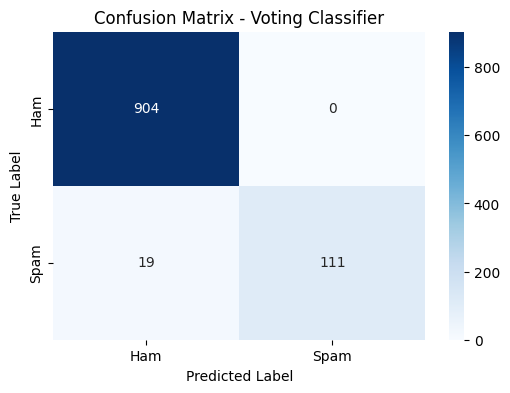

In [57]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, 
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = voting.predict(X_test_vec)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Voting Classifier')
plt.show()


ROC AUC Score: 0.9824710687542546


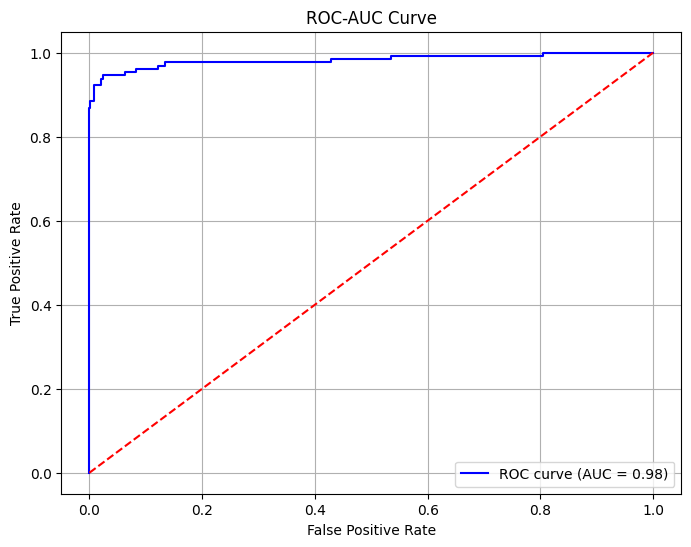

In [58]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities for positive class (Spam = 1)
y_prob = voting.predict_proba(X_test_vec)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Applying stacking**

In [59]:
from sklearn.ensemble import StackingClassifier

In [60]:
final_estimator=RandomForestClassifier()

clf = StackingClassifier(estimators=[('B_NB', bnb),('rf',rfc),('et',etc)], final_estimator=final_estimator)

In [61]:
clf.fit(X_train_vec,y_train_new)

,estimators,"[('B_NB', ...), ('rf', ...), ...]"
,final_estimator,RandomForestClassifier()
,cv,None
,stack_method,'auto'
,n_jobs,None
,passthrough,False
,verbose,0
,alpha,1.0
,force_alpha,True
,binarize,0.0
,fit_prior,True


Accuracy: 0.9835589941972921
Precision: 0.991304347826087
Recall: 0.8769230769230769
F1 Score: 0.9306122448979591

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       904
           1       0.99      0.88      0.93       130

    accuracy                           0.98      1034
   macro avg       0.99      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



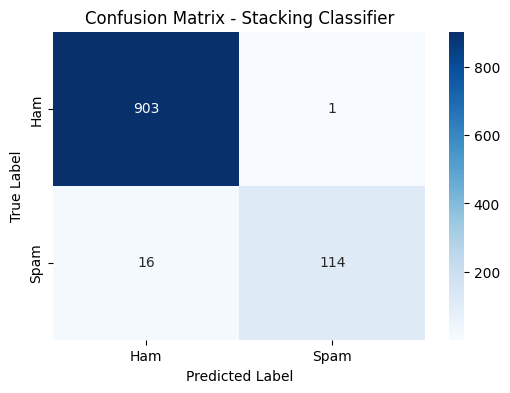

In [62]:
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions using StackingClassifier
y_pred_stack = clf.predict(X_test_vec)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred_stack))
print("Precision:", precision_score(y_test, y_pred_stack))
print("Recall:", recall_score(y_test, y_pred_stack))
print("F1 Score:", f1_score(y_test, y_pred_stack))
print("\nClassification Report:\n", classification_report(y_test, y_pred_stack))

# Confusion matrix
cm_stack = confusion_matrix(y_test, y_pred_stack)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(
    cm_stack, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Stacking Classifier')
plt.show()


ROC AUC Score: 0.9778420694349897


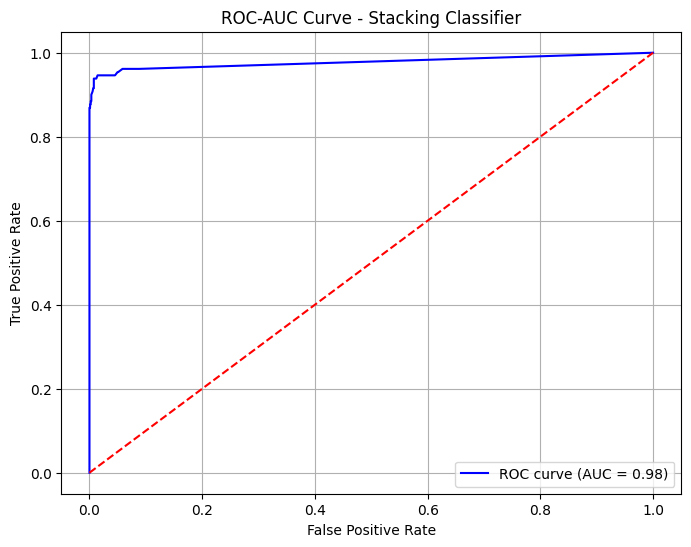

In [63]:
# Get predicted probabilities for positive class (Spam = 1)
y_prob_stack = clf.predict_proba(X_test_vec)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_stack)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob_stack)
print("ROC AUC Score:", auc_score)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve - Stacking Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
